[![](https://colab.research.google.com/assets/colab-badge.svg "Open in Colab button")](https://colab.research.google.com/github/thinkingmachines/geowrangler/blob/master/notebooks/02_vector_zonal_stats.ipynb)

In [ ]:
#| default_exp vector_zonal_stats

In [ ]:
#| include: false
#| no_test
! [ -e /content ] && pip install -Uqq geowrangler
! [ -e /content ] && pip install -Uqq nbdev

In [ ]:
#| include: false
#| no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#| include: false
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

In [ ]:
#| exporti
GEO_INDEX_NAME = "__GeoWrangleer_aoi_index"

In [ ]:
#| export
from functools import partial
from typing import Any, Dict, List

import geopandas as gpd
import morecantile
import numpy as np
import pandas as pd

### Aggregations

In order to generate zonal stats for an area (or areas) of interest (aoi) , we have come up with the concept of an **aggregation specification** or _agg spec_, which is a way to specify what aggregation functions (such as `count`,`sum`, `mean`,`std` etc.) are to be applied to columns in the source dataframe (data). 

The method `create_zonal_stats` can then take in a list of these _agg specs_ and apply them to create zonal stats from the data for the aoi.

Each _agg spec_ consists of a `dict` with the following keys:

* `func`: (Required) a `str` or a list `[str]` of aggregation functions. See the pandas documentation for [agg](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html)

* `column`: (Optional) an existing column in the data to generate the zonal statistic from. If not specified, the grouping key based on the index of the aoi applied to the data is used as default.

* `output`: (Optional) a `str` or a list `[str]` of the name(s) of the output zonal statistic column. If not specified it is concatenated from the column and func i.e.  `{column}_{func}` (e.g. `'func':'mean'` on `'column':'population'` has a default value `'output':'population_mean'`) 

* `fillna`: (Optional) a `bool` or a list `[bool]` of the flag(s) that indicates whether to to a `fillna(0)` step for the new zonal column, `True` meaning it will set any `NA` values in the resulting zonal stat to `0`, and `False` will retain any `NA` values. The default value of the flag(s) is `False`.



**Examples**

* The simplest aggregation spec. This will result in an output column named `index_count` as it will use the aoi index as the default column. 

```
{"func":"count"}
```

* The `sum` function is applied to the data column `population` which will create an output column named `total_population`.

```
{
 "func:"sum",
 "column": "population",
 "output": "total_population"
}
```

* Compute the zonal stats `mean`,`sum`,`max` on the `population` column and rename the output columns (by default) to `population_mean`, `population_sum` and `population_max`.

```
{
 "func": ["mean","sum","max"],
 "column": "population",
}
 ```

* A full aggregation spec with `fillna`. `fillna == False` for `std` means it will remain an `NA` if there is no data for the column in the group. The default value for `fillna` is `True` which means that `0` is used to replace any `NA` in the output column.
```
{
 "func": ["mean", "sum", "std"],
 "column":"population",
 "output": ["avg_pop", "total_pop", "std_dev"],
 "fillna": [True,True,False],
}
```

The `agg spec` in the list of aggregations can contain the same columns, but the output columns must be unique since they will added as columns in the results.


### Regular and Grid Zonal Stats
> Vector zonal stats for user defined areas and grids (e.g. Admin areas)

In [ ]:
#| exporti
def _fix_agg(
    agg: Dict[str, Any],  # A dict containing at the minimum a 'func' key
) -> Dict[str, Any]:
    """
    Fix an `agg spec`.

    It outputs a dict containing the following keys:
      - 'func': a list of aggregation functions (should be a valid 'agg' function)
      - 'column': a column to apply the aggregation functions (should be a valid numeric column in data)
      - 'output': the names of the new columns containing the application of the aggregation functions (default: concat column + '_' + func)
      - 'fillna': boolean list whether to replace new columns with 'NA' values  with 0 (default: False)
    """
    if "func" not in agg:
        return agg  # skip fix as agg spec is invalid

    if type(agg["func"]) == str:
        agg["func"] = [agg["func"]]

    # optional column, default to index count
    if "column" not in agg:
        agg["column"] = GEO_INDEX_NAME

    if "output" not in agg:
        column = "index" if agg["column"] == GEO_INDEX_NAME else agg["column"]
        agg["output"] = [f"{column}_{f}" for f in agg["func"]]

    if type(agg["output"]) == str:
        agg["output"] = [agg["output"]]

    # check matching fillna
    if "fillna" not in agg:
        agg["fillna"] = [False for _ in agg["func"]]

    if type(agg["fillna"]) == bool:
        agg["fillna"] = [agg["fillna"]]

    return agg

In [ ]:
#| include: false
assert _fix_agg({"func": ["sum", "max", "min", "mean"], "column": "population"}) == {
    "func": ["sum", "max", "min", "mean"],
    "column": "population",
    "output": ["population_sum", "population_max", "population_min", "population_mean"],
    "fillna": [False, False, False, False],
}

In [ ]:
#| include: false
assert _fix_agg({"func": "count"}) == {
    "func": ["count"],
    "column": GEO_INDEX_NAME,
    "output": ["index_count"],
    "fillna": [False],
}

In [ ]:
#| include: false
assert _fix_agg(
    {
        "func": ["sum", "max", "min", "mean", "std"],
        "column": "population",
        "output": ["pop_sum", "pop_max", "pop_min", "avg_pop", "pop_std_dev"],
        "fillna": [True, True, True, True, False],
    }
) == {
    "func": ["sum", "max", "min", "mean", "std"],
    "column": "population",
    "output": ["pop_sum", "pop_max", "pop_min", "avg_pop", "pop_std_dev"],
    "fillna": [True, True, True, True, False],
}

In [ ]:
#| include: false
assert _fix_agg({"func": "count"}) == {
    "func": ["count"],
    "column": GEO_INDEX_NAME,
    "output": ["index_count"],
    "fillna": [False],
}

In [ ]:
#| exporti
def _check_agg(
    agg: Dict[str, Any],  # A dict containing at the minimum a 'func' key
    i: int,  # The index into the list of aggregations
    data_cols: List[str],  # list of data columns
    dtypes: pd.Series,  # series of dtypes with column names as index
) -> None:
    """
    Validate an `agg spec`.
    """

    if "func" not in agg:
        raise ValueError(f"Missing key 'func' in agg[{i}] {agg}")

    for func in agg["func"]:
        if getattr(pd.Series, func, None) is None:
            raise ValueError(f"Unknown func '{func}' in agg[{i}] {agg}")

    if agg["column"] != GEO_INDEX_NAME and agg["column"] not in data_cols:
        raise ValueError(
            f"Column '{agg['column']}' in agg[{i}] {agg} does not exist in the data"
        )

    if agg["column"] != GEO_INDEX_NAME and not np.issubdtype(
        dtypes.loc[agg["column"]], np.number
    ):
        raise ValueError(
            f"Column '{agg['column']}' in agg[{i}] {agg} is not a numeric column in the data"
        )

    if len(agg["func"]) != len(agg["output"]):
        raise ValueError(
            f"output list {agg['output']} doesn't match func list {agg['func']} in agg[{i}] {agg}"
        )

    # check matching fillna
    if len(agg["fillna"]) != len(agg["func"]):
        raise ValueError(
            f"fillna list {agg['fillna']} doesn't match func list {agg['func']} in agg[{i}] {agg}"
        )

In [ ]:
#| include: false
try:
    _check_agg({}, 0, [], pd.Series(dtype=np.float64))
    threw_exception = False
except ValueError as e:
    threw_exception = True
    assert e.args[0] == "Missing key 'func' in agg[0] {}"
assert threw_exception

In [ ]:
#| include: false
try:
    _check_agg(
        {"func": ["mean", "sum"], "column": "population", "output": ["pop_mean"]},
        1,
        ["population"],
        pd.Series(data={"population": np.dtype(np.int32)}),
    )
    threw_exception = False
except ValueError as e:
    threw_exception = True
    assert (
        e.args[0]
        == "output list ['pop_mean'] doesn't match func list ['mean', 'sum'] in agg[1] {'func': ['mean', 'sum'], 'column': 'population', 'output': ['pop_mean']}"
    )
assert threw_exception

In [ ]:
#| exporti
def _validate_aggs(
    fixed_aggs: List[Dict[str, Any]],  # A list of fixed agg specs
    data: pd.DataFrame,  # Source dataframe
) -> None:
    data_cols = list(data.columns.values)
    outputs = []
    for i, agg in enumerate(fixed_aggs):
        _check_agg(agg, i, data_cols, data.dtypes)
        # check duplicate outputs
        if any(item in agg["output"] for item in outputs):
            raise ValueError(
                f"Duplicate output column name found for agg[{i}] {agg['output']}"
            )
        outputs += agg["output"]

In [ ]:
#| include: false
try:
    _validate_aggs(
        [{"func": ["mean", "sum"], "column": "population", "output": ["pop_mean"]}],
        pd.DataFrame(data={"population": [1, 2, 3]}),
    )
    threw_exception = False
except ValueError as e:
    threw_exception = True
    assert (
        e.args[0]
        == "output list ['pop_mean'] doesn't match func list ['mean', 'sum'] in agg[0] {'func': ['mean', 'sum'], 'column': 'population', 'output': ['pop_mean']}"
    )
assert threw_exception

In [ ]:
#| include: false
try:
    _validate_aggs(
        [
            {
                "func": ["mean", "sum"],
                "column": "population",
                "output": ["pop_mean", "pop_total"],
                "fillna": [True, True],
            }
        ],
        pd.DataFrame(data={"population": [1, 2, 3]}),
    )
    threw_exception = False
except ValueError:
    threw_exception = True
assert not threw_exception

In [ ]:
#| include: false
try:
    _validate_aggs(
        [
            {
                "func": ["mean", "sum"],
                "column": "population",
                "output": ["pop_mean", "pop_total"],
                "fillna": [True, True],
            },
            {
                "func": ["mean", "sum"],
                "column": "dads",
                "output": ["pop_mean", "pop_total"],
                "fillna": [True, True],
            },
        ],
        pd.DataFrame(data={"population": [1, 2, 3], "dads": [5, 6, 7]}),
    )
    threw_exception = False
except ValueError as e:
    threw_exception = True
    assert (
        e.args[0]
        == "Duplicate output column name found for agg[1] ['pop_mean', 'pop_total']"
    )
assert threw_exception

In [ ]:
#| include: false
# TODO - more tests for validating aggs

In [ ]:
#| exporti
def _validate_aoi(
    aoi: pd.DataFrame,  # Source dataframe
) -> None:
    if isinstance(aoi.index, pd.MultiIndex):
        raise ValueError(
            "AOI has a pandas.MultiIndex. Please convert the index to a single level such as pd.RangeIndex"
        )

In [ ]:
#| exporti
def _expand_aggs(
    aggs: List[Dict[str, Any]],  # List of fixed valid aggs
) -> List[Dict[str, Any]]:
    """Expands agg specs with multiple funcs each into a separate agg spec"""
    expanded_aggs = []
    for agg in aggs:
        for i, func in enumerate(agg["func"]):
            expanded_agg = {
                "func": func,
                "column": agg["column"],
                "output": agg["output"][i],
                "fillna": agg["fillna"][i],
            }
            expanded_aggs += [expanded_agg]
    return expanded_aggs

In [ ]:
#| include: false
assert _expand_aggs(
    [
        {
            "func": ["mean", "sum"],
            "column": "population",
            "output": ["pop_mean", "pop_total"],
            "fillna": [True, True],
        },
        {
            "func": ["mean", "sum"],
            "column": "dads",
            "output": ["dad_mean", "dad_total"],
            "fillna": [True, True],
        },
    ],
) == [
    {"func": "mean", "column": "population", "output": "pop_mean", "fillna": True},
    {"func": "sum", "column": "population", "output": "pop_total", "fillna": True},
    {"func": "mean", "column": "dads", "output": "dad_mean", "fillna": True},
    {"func": "sum", "column": "dads", "output": "dad_total", "fillna": True},
]

In [ ]:
#| exporti
def _build_agg_args(
    aggs: List[Dict[str, Any]],  # A list of expanded aggs
) -> Dict:
    """Builds a dict of args with output as key and a tuple of column and func as value from a list of expanded aggs"""
    return {agg["output"]: (agg["column"], agg["func"]) for agg in aggs}

In [ ]:
#| include: false

assert _build_agg_args(
    [
        {"func": "mean", "column": "population", "output": "pop_mean", "fillna": True},
        {"func": "sum", "column": "population", "output": "pop_total", "fillna": True},
        {"func": "mean", "column": "dads", "output": "dad_mean", "fillna": True},
        {"func": "sum", "column": "dads", "output": "dad_total", "fillna": True},
    ]
) == {
    "pop_mean": ("population", "mean"),
    "pop_total": ("population", "sum"),
    "dad_mean": ("dads", "mean"),
    "dad_total": ("dads", "sum"),
}

In [ ]:
#| exporti


def _prep_aoi(
    aoi: pd.DataFrame,  # Area of interest
) -> pd.DataFrame:
    """
    Prepare aoi for spatial join
      - create a column  from aoi's index which will be used as grouping key
    """
    if GEO_INDEX_NAME in list(aoi.columns.values):
        raise ValueError(
            f"Invalid column name error: AOI column should not match Geowrangler index column {GEO_INDEX_NAME}"
        )
    # prep for spatial join
    aoi = aoi.copy()
    aoi.index.name = GEO_INDEX_NAME

    # create index col for broadcast to features
    aoi = aoi.reset_index(level=0)  # index added as new column named GEO_INDEX_NAME
    return aoi

In [ ]:
#| include: false
test_aoi = pd.DataFrame(data={"col1": [1, 2, 3]})
result = _prep_aoi(test_aoi)
assert any(
    colname in list(result.columns.values)
    for colname in [*list(test_aoi.columns.values), GEO_INDEX_NAME]
)
assert result.index.name is None

In [ ]:
#| include: false
test_aoi = pd.DataFrame(data={"col1": [1, 2, 3], "index": [5, 6, 7]})
result = _prep_aoi(test_aoi)
assert any(
    colname in list(result.columns.values)
    for colname in [*list(test_aoi.columns.values), GEO_INDEX_NAME]
)
assert result.index.name is None

In [ ]:
#| include: false
test_aoi = pd.DataFrame(data={"col1": [1, 2, 3]})
test_aoi.index.name = "myindex"
result = _prep_aoi(test_aoi)
assert any(
    colname in list(result.columns.values)
    for colname in [*list(test_aoi.columns.values), GEO_INDEX_NAME]
)
assert result.index.name is None

In [ ]:
#| include: false
# TODO - add tests
# - show addition of aoi_index
# - show split if existing column index
# - show split if existing column aoi_index

In [ ]:
#| exporti


def _fillnas(
    expanded_aggs: List[Dict[str, Any]],  # list of expanded aggs
    results: pd.DataFrame,  # results dataframe to be filled with NAs if flag set
    aoi: pd.DataFrame,  # aoi dataframe to merge it back to
) -> pd.DataFrame:
    results = results.copy()
    # set NAs to 0 if fillna
    for agg in expanded_aggs:
        if agg["fillna"]:
            colname = agg["output"]
            if colname in list(aoi.columns.values):
                colname = colname + "_y"  # try if merged df has colname + _y
            if colname in list(results.columns.values):
                # following this guide https://medium.com/@felipecaballero/deciphering-the-cryptic-futurewarning-for-fillna-in-pandas-2-01deb4e411a1
                with pd.option_context('future.no_silent_downcasting', True):
                    results[colname] = results[colname].fillna(0).infer_objects(copy=False)

    return results

In [ ]:
#| include: false
results = pd.DataFrame(data={"pop_total": [pd.NA, pd.NA, 5]})
aoi = pd.DataFrame(data={"col1": [1, 2, 3]})
results = _fillnas([{"output": "pop_total", "fillna": True}], results, aoi)
assert results.equals(pd.DataFrame(data={"pop_total": [0, 0, 5]}))

In [ ]:
#| include: false
results = pd.DataFrame(data={"pop_total": [pd.NA, pd.NA, 5]})
aoi = pd.DataFrame(data={"col1": [1, 2, 3]})
results = _fillnas([{"output": "pop_total", "fillna": False}], results, aoi)
assert results.equals(pd.DataFrame(data={"pop_total": [pd.NA, pd.NA, 5]}))

In [ ]:
#| include: false
results = pd.DataFrame(data={"pop_total_y": [pd.NA, pd.NA, 5]})
aoi = pd.DataFrame(data={"pop_total": [1, 2, 3]})
results = _fillnas([{"output": "pop_total", "fillna": True}], results, aoi)
assert results.equals(pd.DataFrame(data={"pop_total_y": [0, 0, 5]}))

In [ ]:
#| exporti


def _aggregate_stats(
    aoi: pd.DataFrame,  # Area of interest
    groups: pd.core.groupby.DataFrameGroupBy,  # Source data aggregated into groups by GEO_INDEX_NAME
    expanded_aggs: List[Dict[str, Any]],  # A list of expanded aggs
) -> pd.DataFrame:
    """Aggregate groups and compute the agg['func'] for agg['column'], map them to the output column in agg['column'] for all the aggs in the expanded_aggs list
    and merge them back to aoi dataframe
    """
    agg_dicts = _build_agg_args(expanded_aggs)
    aggregates = groups.agg(**agg_dicts)
    results = aoi.merge(
        aggregates, how="left", on=GEO_INDEX_NAME, suffixes=(None, "_y")
    )
    results = _fillnas(expanded_aggs, results, aoi)

    return results

In [ ]:
#| include: false
expanded_aggs = [
    {"func": "mean", "column": "population", "output": "pop_mean", "fillna": True},
    {"func": "sum", "column": "population", "output": "pop_total", "fillna": True},
    {"func": "mean", "column": "dads", "output": "dad_mean", "fillna": True},
    {"func": "sum", "column": "dads", "output": "dad_total", "fillna": True},
]
aoi = pd.DataFrame(
    data={
        GEO_INDEX_NAME: [
            1,
            2,
            3,
        ],
        "col1": ["a", "b", "c"],
    }
)
features = pd.DataFrame(
    data={
        GEO_INDEX_NAME: [1, 1, 1, 2, 2, 2, 3, 3, 3],
        "population": [1, 2, 3, 4, 5, 6, 7, 8, 9],
        "dads": [10, 20, 30, 40, 50, 60, pd.NA, pd.NA, pd.NA],
    }
)
features["dads"] = pd.to_numeric(features["dads"])  # change type from object to numeric
groups = features.groupby(GEO_INDEX_NAME)

In [ ]:
#| include: false
expected_df = pd.DataFrame(
    data={
        GEO_INDEX_NAME: [1, 2, 3],
        "col1": ["a", "b", "c"],
        "pop_mean": [2.0, 5.0, 8.0],
        "pop_total": [6, 15, 24],
        "dad_mean": [20.0, 50.0, 0.0],
        "dad_total": [60.0, 150, 0],
    }
)

In [ ]:
#| include: false
actual_df = _aggregate_stats(aoi, groups, expanded_aggs)

In [ ]:
#| include: false
assert actual_df.equals(expected_df)

In [ ]:
#| include: false
# TODO:
# - setup aggregate stats inputs
# - show examples of aggregate stats

In [ ]:
#| export


def create_zonal_stats(
    aoi: gpd.GeoDataFrame,  # Area of interest for which zonal stats are to be computed for
    data: gpd.GeoDataFrame,  # Source gdf containing data to compute zonal stats from
    aggregations: List[  # List of agg specs, with each agg spec applied to a data column
        Dict[str, Any]
    ],
    overlap_method: str = "intersects",  # spatial predicate to used in spatial join of aoi and data [geopandas.sjoin](https://geopandas.org/en/stable/docs/user_guide/mergingdata.html#binary-predicate-joins) for more details
    # categorical_column_options: str = None,
) -> gpd.GeoDataFrame:
    """
    Create zonal stats for area of interest from data using aggregration operations on data columns.
    Returns the same aoi with additional columns containing the computed zonal features.
    """
    _validate_aoi(aoi)
    fixed_aggs = [_fix_agg(agg) for agg in aggregations]

    _validate_aggs(fixed_aggs, data)

    # prep for spatial join
    aoi_index_name = aoi.index.name
    aoi = _prep_aoi(aoi)

    if not data.crs.equals(aoi.crs):
        data = data.to_crs(aoi.crs)

    # spatial join - broadcast aoi_index to data => features
    features = gpd.sjoin(
        aoi[[GEO_INDEX_NAME, "geometry"]], data, how="inner", predicate=overlap_method
    )

    # group
    groups = features.groupby(GEO_INDEX_NAME)

    # apply all aggregations all at once
    expanded_aggs = _expand_aggs(fixed_aggs)
    results = _aggregate_stats(aoi, groups, expanded_aggs)

    # cleanup results
    results = results.set_index(GEO_INDEX_NAME)
    results.index.name = aoi_index_name

    return results

In [ ]:
#| include: false
# setup for create_zonal_stats test
# see tests/test_vector_zonal_stats.py
def make_simple_aoi():
    df = pd.DataFrame(
        data={
            "col1": [1, 2, 3],
            "lat0": [0.0, 1.0, 2.0],
            "lon0": [0.0, 0.0, 0.0],
            "lat1": [0.0, 1.0, 2.0],
            "lon1": [1.0, 1.0, 1.0],
            "lat2": [1.0, 2.0, 3.0],
            "lon2": [1.0, 1.0, 1.0],
            "lat3": [1.0, 2.0, 3.0],
            "lon3": [0.0, 0.0, 0.0],
        }
    )

    def square(row):
        return Polygon(
            (
                [
                    (row.lat0, row.lon0),
                    (row.lat1, row.lon1),
                    (row.lat2, row.lon2),
                    (row.lat3, row.lon3),
                ]
            )
        )

    return gpd.GeoDataFrame(df, geometry=df.apply(square, axis=1), crs="EPSG:4326")


def make_simple_data():
    df = pd.DataFrame(
        data={
            "col1": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
            "lat": [
                0.5,
                1.5,
                2.5,
                0.45,
                1.45,
                2.45,
                0.45,
                1.45,
                2.45,
                0.45,
                1.45,
                2.45,
            ],
            "lon": [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.45, 0.45, 0.45, 1.45, 1.45, 1.45],
        }
    )
    return gpd.GeoDataFrame(
        df,
        geometry=df.apply(lambda row: Point(row.lat, row.lon), axis=1),
        crs="EPSG:4326",
    )


simple_aoi = make_simple_aoi()
simple_data = make_simple_data()

In [ ]:
simple_aoi  # sample aoi

,col1,lat0,lon0,lat1,lon1,lat2,lon2,lat3,lon3,geometry
0,1,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,"POLYGON ((0 0, 0 1, 1 1, 1 0, 0 0))"
1,2,1.0,0.0,1.0,1.0,2.0,1.0,2.0,0.0,"POLYGON ((1 0, 1 1, 2 1, 2 0, 1 0))"
2,3,2.0,0.0,2.0,1.0,3.0,1.0,3.0,0.0,"POLYGON ((2 0, 2 1, 3 1, 3 0, 2 0))"


In [ ]:
simple_data  # sample data

,col1,lat,lon,geometry
0,1,0.50,0.50,POINT (0.5 0.5)
1,2,1.50,0.50,POINT (1.5 0.5)
2,3,2.50,0.50,POINT (2.5 0.5)
3,4,0.45,0.50,POINT (0.45 0.5)
4,5,1.45,0.50,POINT (1.45 0.5)
5,6,2.45,0.50,POINT (2.45 0.5)
6,7,0.45,0.45,POINT (0.45 0.45)
7,8,1.45,0.45,POINT (1.45 0.45)
8,9,2.45,0.45,POINT (2.45 0.45)
9,10,0.45,1.45,POINT (0.45 1.45)


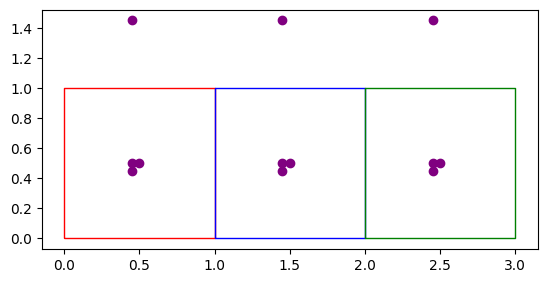

In [ ]:
ax = simple_aoi.plot(
    ax=plt.axes(), facecolor="none", edgecolor=["red", "blue", "green"]
)
ax = simple_data.plot(ax=ax, color="purple")

In [ ]:
results = create_zonal_stats(simple_aoi, simple_data, aggregations=[{"func": "count"}])
results

,col1,lat0,lon0,lat1,lon1,lat2,lon2,lat3,lon3,geometry,index_count
0,1,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,"POLYGON ((0 0, 0 1, 1 1, 1 0, 0 0))",3
1,2,1.0,0.0,1.0,1.0,2.0,1.0,2.0,0.0,"POLYGON ((1 0, 1 1, 2 1, 2 0, 1 0))",3
2,3,2.0,0.0,2.0,1.0,3.0,1.0,3.0,0.0,"POLYGON ((2 0, 2 1, 3 1, 3 0, 2 0))",3


In [ ]:
#| include: false
assert any(
    item in list(results.columns.values)
    for item in [*list(simple_aoi.columns.values), "index_count"]
)
assert results.index_count.sum() == 9
assert results.iloc[0].index_count == 3

In [ ]:
#| include: false
assert isinstance(results.index, pd.Index)

Index name is not none

In [ ]:
named_index_aoi = simple_aoi.copy()
named_index_aoi.index.name = "myindex"

In [ ]:
named_index_aoi

,col1,lat0,lon0,lat1,lon1,lat2,lon2,lat3,lon3,geometry
myindex,,,,,,,,,,
0,1,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,"POLYGON ((0 0, 0 1, 1 1, 1 0, 0 0))"
1,2,1.0,0.0,1.0,1.0,2.0,1.0,2.0,0.0,"POLYGON ((1 0, 1 1, 2 1, 2 0, 1 0))"
2,3,2.0,0.0,2.0,1.0,3.0,1.0,3.0,0.0,"POLYGON ((2 0, 2 1, 3 1, 3 0, 2 0))"


In [ ]:
named_index_results = create_zonal_stats(
    named_index_aoi, simple_data, aggregations=[{"func": "count"}]
)

In [ ]:
named_index_results.head()

,col1,lat0,lon0,lat1,lon1,lat2,lon2,lat3,lon3,geometry,index_count
myindex,,,,,,,,,,,
0,1,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,"POLYGON ((0 0, 0 1, 1 1, 1 0, 0 0))",3
1,2,1.0,0.0,1.0,1.0,2.0,1.0,2.0,0.0,"POLYGON ((1 0, 1 1, 2 1, 2 0, 1 0))",3
2,3,2.0,0.0,2.0,1.0,3.0,1.0,3.0,0.0,"POLYGON ((2 0, 2 1, 3 1, 3 0, 2 0))",3


In [ ]:
#| include: false
assert isinstance(named_index_results.index, pd.Index)

In [ ]:
#| include: false
assert named_index_results.index.name == "myindex"

### Bing Map Tile Grid Zonal Stats 
> Generating zonal stats for Bing tile grid AOIs

In [ ]:
#| exporti

tms = morecantile.tms.get("WebMercatorQuad")  # Tile Matrix for Bing Maps

In [ ]:
#| exporti


def get_quadkey(geometry, zoom_level):
    return tms.quadkey(tms.tile(geometry.x, geometry.y, zoom_level))

In [ ]:
#| export


def compute_quadkey(
    data: gpd.GeoDataFrame,  # The geodataframe
    zoom_level: int,  # The quadkey zoom level (1-23)
    quadkey_column: str = "quadkey",  # The name of the quadkey output column
) -> gpd.GeoDataFrame:
    """
    Computes the quadkeys for the geometries of the data.
    If geometries are not points, the quadkeys are computed
    from the centroids of the geometries.
    """

    data = data.copy()

    get_zoom_quadkey = partial(get_quadkey, zoom_level=zoom_level)

    if data.crs.is_geographic:
        centroids = data.to_crs("EPSG:3857").geometry.centroid  # planar
        centroids = centroids.to_crs(data.crs)
    else:
        centroids = data.geometry.centroid
        centroids = centroids.to_crs("EPSG:4326")  # use geographic

    data[quadkey_column] = centroids.apply(get_zoom_quadkey)

    return data

If our existing data geodataframe doesn't have quadkeys,
we can use the `compute_quadkey` to generate the quadkeys
for the centroid of the data's geometries.


In [ ]:
%%time
DATA_ZOOM_LEVEL = 19
AOI_ZOOM_LEVEL = 9
simple_data_quadkey = compute_quadkey(simple_data, DATA_ZOOM_LEVEL)

CPU times: user 4.32 ms, sys: 684 µs, total: 5 ms
Wall time: 4.98 ms


In [ ]:
simple_data_quadkey.head()

,col1,lat,lon,geometry,quadkey
0,1,0.50,0.5,POINT (0.5 0.5),1222222221211211222
1,2,1.50,0.5,POINT (1.5 0.5),1222222320210201222
2,3,2.50,0.5,POINT (2.5 0.5),1222222331200311222
3,4,0.45,0.5,POINT (0.45 0.5),1222222221210201333
4,5,1.45,0.5,POINT (1.45 0.5),1222222320200311333


In [ ]:
#| include: false
simple_data_quadkey2 = compute_quadkey(simple_data.to_crs("EPSG:3857"), DATA_ZOOM_LEVEL)

In [ ]:
#| include: false
assert (simple_data_quadkey2.quadkey == simple_data_quadkey.quadkey).all(axis=None)

In [ ]:
#| include: false
assert (simple_data_quadkey.quadkey.apply(len) == DATA_ZOOM_LEVEL).all()

In [ ]:
#| exporti


def validate_aoi_quadkey(aoi, aoi_quadkey_column) -> None:

    if aoi_quadkey_column not in list(aoi.columns.values):
        raise ValueError(
            f"aoi_quadkey_column '{aoi_quadkey_column}' is not in list of aoi columns: {list(aoi.columns.values)}"
        )
    if len(aoi) == 0:
        raise ValueError("aoi dataframe is empty")

    aoi_zoom_level = len(aoi[aoi_quadkey_column].iloc[0])
    if not (aoi[aoi_quadkey_column].apply(len) == aoi_zoom_level).all(axis=None):
        raise ValueError("aoi quadkey levels are not all at the same level")


def validate_data_quadkey(data, data_quadkey_column, min_zoom_level):
    if data_quadkey_column not in list(data.columns.values):
        raise ValueError(
            f"data_quadkey_column '{data_quadkey_column}' is not in list of data columns: {list(data.columns.values)}"
        )
    if len(data) == 0:
        raise ValueError("data dataframe is empty")

    if not (data[data_quadkey_column].apply(len) >= min_zoom_level).all(axis=0):
        raise ValueError(
            f"data quadkey levels cannot be less than aoi quadkey level {min_zoom_level}"
        )

In [ ]:
#| export


def create_bingtile_zonal_stats(
    aoi: pd.DataFrame,  # An aoi with quadkey column
    data: pd.DataFrame,  # Data with  quadkey column
    aggregations: List[  # List of agg specs, with each agg spec applied to a data column
        Dict[str, Any]
    ],
    aoi_quadkey_column: str = "quadkey",  # Column name of aoi quadkey
    data_quadkey_column: str = "quadkey",  # Column name of data quadkey
) -> pd.DataFrame:

    data = data.copy()
    aoi = aoi.copy()

    aoi[aoi_quadkey_column] = aoi[aoi_quadkey_column].apply(str)
    data[data_quadkey_column] = data[data_quadkey_column].apply(str)

    # validate aoi zoom level is same for all rows
    validate_aoi_quadkey(aoi, aoi_quadkey_column)
    # get aoi zoom level
    aoi_zoom_level = len(aoi[aoi_quadkey_column].iloc[0])

    validate_data_quadkey(data, data_quadkey_column, aoi_zoom_level)

    fixed_aggs = [_fix_agg(agg) for agg in aggregations]

    _validate_aggs(fixed_aggs, data)

    # create aoi level quad_key for data (apply quadkey_to_tile)
    def quadkey4zoom_level(x):
        return x[:aoi_zoom_level]

    data[GEO_INDEX_NAME] = data[data_quadkey_column].apply(quadkey4zoom_level)

    # filter data to include only those whose quadkeys are in aoi quadkeys
    features = data.join(
        aoi[[aoi_quadkey_column]].set_index(aoi_quadkey_column),
        how="inner",
        on=GEO_INDEX_NAME,
    )

    # groupby data on aoi level quad key
    groups = features.groupby(GEO_INDEX_NAME)

    expanded_aggs = _expand_aggs(fixed_aggs)
    aoi[GEO_INDEX_NAME] = aoi[aoi_quadkey_column]

    results = _aggregate_stats(aoi, groups, expanded_aggs)

    results = results.drop(columns=[GEO_INDEX_NAME])

    return results

To create bingtile zonal stats, we need to compute the quadkeys for
the areas of interest (AOI) and the data.

The `geowrangler.grids` module provides a `BingTileGridGenerator` that
will generate the quadkeys for the areas covered by your AOIs. 

In [ ]:
import geowrangler.grids as gr

In [ ]:
bgtile_generator = gr.BingTileGridGenerator(AOI_ZOOM_LEVEL)
simple_aoi_bingtiles = bgtile_generator.generate_grid(simple_aoi)

Using the data with the computed quadkeys,
we can generate zonal stats for our bingtile grid aois.
This just uses the regular pandas grouping and merging function
and skips any geospatial joins which results in faster computation.

In [ ]:
%%time
bingtile_results = create_bingtile_zonal_stats(
    simple_aoi_bingtiles,
    simple_data_quadkey,
    aggregations=[dict(func="count", fillna=True)],
)

CPU times: user 5.02 ms, sys: 438 µs, total: 5.46 ms
Wall time: 6.08 ms


In [ ]:
bingtile_results

,quadkey,geometry,index_count
0,122222220,"POLYGON ((0 0.70311, 0 1.40611, 0.70312 1.4061...",0.0
1,122222221,"POLYGON ((0.70312 0.70311, 0.70312 1.40611, 1....",0.0
2,122222230,"POLYGON ((1.40625 0.70311, 1.40625 1.40611, 2....",0.0
3,122222231,"POLYGON ((2.10937 0.70311, 2.10937 1.40611, 2....",0.0
4,122222320,"POLYGON ((2.8125 0.70311, 2.8125 1.40611, 3.51...",0.0
5,122222222,"POLYGON ((0 0, 0 0.70311, 0.70312 0.70311, 0.7...",3.0
6,122222223,"POLYGON ((0.70312 0, 0.70312 0.70311, 1.40625 ...",0.0
7,122222232,"POLYGON ((1.40625 0, 1.40625 0.70311, 2.10937 ...",3.0
8,122222233,"POLYGON ((2.10937 0, 2.10937 0.70311, 2.8125 0...",3.0
9,122222322,"POLYGON ((2.8125 0, 2.8125 0.70311, 3.51562 0....",0.0


In [ ]:
#| include: false
assert sorted(list(bingtile_results.quadkey.values)) == sorted([
    "122222220",
    "122222222",
    "122222221",
    "122222223",
    "122222230",
    "122222232",
    "122222231",
    "122222233",
    "122222320",
    "122222322",
])

In [ ]:
#| include: false
assert list(bingtile_results.index_count.values) == [
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    3.0,
    0.0,
    3.0,
    3.0,
    0.0,
]

We can also use any bingtile grid for any zoom level lower than
the data's zoom level

In [ ]:
bgtile_generator10 = gr.BingTileGridGenerator(AOI_ZOOM_LEVEL + 1)
simple_aoi_bingtiles10 = bgtile_generator10.generate_grid(simple_aoi)

In [ ]:
bingtile_results10 = create_bingtile_zonal_stats(
    simple_aoi_bingtiles10,
    simple_data_quadkey,
    aggregations=[dict(func="count", fillna=True)],
)

In [ ]:
bingtile_results10[bingtile_results10.index_count > 0]

,quadkey,geometry,index_count
10,1222222221,"POLYGON ((0.35156 0.35156, 0.35156 0.70311, 0....",3.0
13,1222222320,"POLYGON ((1.40625 0.35156, 1.40625 0.70311, 1....",3.0
15,1222222330,"POLYGON ((2.10937 0.35156, 2.10937 0.70311, 2....",2.0
16,1222222331,"POLYGON ((2.46094 0.35156, 2.46094 0.70311, 2....",1.0


In [ ]:
#| include: false
assert list(bingtile_results10[bingtile_results10.index_count > 0].quadkey.values) == [
    "1222222221",
    "1222222320",
    "1222222330",
    "1222222331",
]

In [ ]:
#| include: false
assert list(
    bingtile_results10[bingtile_results10.index_count > 0].index_count.values
) == [
    3,
    3,
    2,
    1,
]

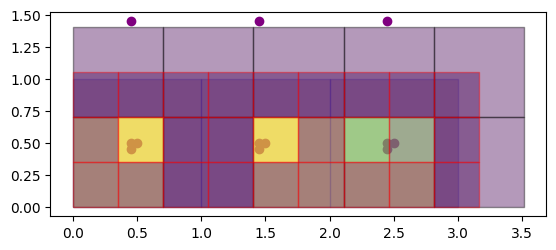

In [ ]:
ax = results.plot(ax=plt.axes(), column="index_count", edgecolor="blue", alpha=0.2)
ax = simple_data.plot(ax=ax, color="purple")
ax = bingtile_results.plot(ax=ax, column="index_count", edgecolor="black", alpha=0.4)
ax = bingtile_results10.plot(ax=ax, column="index_count", edgecolor="red", alpha=0.4)